This notebook is an introduction to the simulations of Non-Terrestrial Networks (NTN) in Sionna based on the channel models from the standard 3GPP TR38.811. 

In this tutorial we will have a brief look on the setup of the NTN channels and their characteristics. To do that, we will generate a few different channels and visualize their characteristics. The usage of the channel model is similar to the channel models from 3GPP TR38.901, which already exist in Sionna.

First, we will import all functions necessary for this notebook. Most functions from Sionna, such as the OFDM modules, coding, and so on, are compatible with the NTN channel models. The only exceptions are parts from the 38.901 channel submodule, such as gen_single_sector_topology and the antennas, which have to be imported from the new functions in the 38.811 channel model subset.  

In [2]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# Import Sionna
import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

import matplotlib.pyplot as plt
import numpy as np

from sionna.phy.ofdm import ResourceGrid
from sionna.phy.channel import subcarrier_frequencies, cir_to_ofdm_channel

# These functions also exist in sionna.channel.tr38901 but are not compatable with 3GPP TR38.811
from sionna.phy.channel.tr38811 import Antenna, AntennaArray
from sionna.phy.channel.tr38811.utils import gen_single_sector_topology as gen_ntn_topology
from sionna.phy.channel.tr38811 import DenseUrban, Urban, SubUrban

Next, we set our variables for our simulations. The NTN simulations, just like the terrestrial simulations using 3GPP TR38.901, require a 3D topology, in which a number of user terminals (UT) and a base station (bs) are placed. The basestation will always be the satellite in our examples in this notebook. Between the base station and each user is a communication link with certain characteristics we will exaplin further down in this notebook. To generate these charactersics, a set of parameters need to be chosen by the user. The first is the scenario, which can be dense urban (dur), urban (urb), or suburban (sur). The scenario defines the environment in which the users are. Next, the direction needs to be set to either uplink (UL) or downlink (DL). Based on the direction, different carrier frequencies in the Ka-Band and S-Band are of particular interest. These are for Ka-Band 19.7–21.2 GHz in DL and 29.5–30.0 GHz in UL. For the S-Band they are 1.98–2.01 GHz in UL and 2.17–2.2 GHz in DL. In general, all parameters in S-Band (1.9GHz-4GHz) and Ka-Band (19GHz-40GHz) are supported. A new parameter in the simulation of NTNs is the elevation angle, which is the angle between the direct line between the satellite and the UT and the horizon. This can be between 90 degrees (satellite is directly above UT) and 10 degrees (satellite is far off in the horizon). Lastly, the satellite height also needs to be added, as the parameters differ based on the satellites' orbit.

All of these parameters influence different aspects, such as the Line of Sigh (LoS) probability, the delay spread for arriving messages, and more. For an explanation of the exact mathematical model, we refer the reader to the standard 3GPP TR38.811.

For this example, we choose the following parameters:

In [3]:
scenario = "dur" # dur is the DenseUrban scenario
carrier_frequency = 2.0e9 # UL S-Band
direction = "uplink"
elevation_angle = 80.0
num_ut = 4
satellite_height = 600000.0 # Height in meters, this is a satellite in the Low Earth Orbit (LEO)
batch_size = 32 # Number of topologies we will generate later  

Now we setup our antennas. For the satellites and UTs different antennas are available. The antenna types are aperture, VSAT, dual-linear-polarized, and omnidirectional. The selection of the adequate antenna depends on the scenario and can be taken from the standard 3GPP TR38.811. It is important to note, that all UTs will have the same antenna type. We choose:

In [4]:
ut_array = Antenna(polarization="single",
                    polarization_type="V",
                    antenna_pattern="omni",
                    carrier_frequency=carrier_frequency)

# The satellite is the basestation, so we name it bs. 
bs_array = AntennaArray(num_rows=1,
                        num_cols=4,
                        polarization="dual",
                        polarization_type="VH",
                        antenna_pattern="38.901",
                        carrier_frequency=carrier_frequency)

With the antennas defined, we now generate a channel model. The channel model has more optional parameters, which can be found in the documentation.

In [5]:
# Here we match choose DenseUrban to match the parameter "dur" for the scenario defined above
channel_model = DenseUrban(carrier_frequency=carrier_frequency,
                        ut_array=ut_array,
                        bs_array=bs_array,
                        direction=direction,
                        elevation_angle=elevation_angle)

As the NTN channels are made to be used like the existing 38.901 channels, we also need a channel topology. However, please note again, that the function to generate this topology is different from the one in 38.901, as the parameters vary slightly. Given our parameters above, we generate the 3D topology and apply it to out channel model.

In [6]:
# Generate the topology
topology = gen_ntn_topology(batch_size=batch_size, num_ut=num_ut, scenario=scenario,bs_height=satellite_height, elevation_angle=90.0)

# Set the topology
channel_model.set_topology(*topology)

Let's visualize the topology and observe a few key differences to the topologies known from TR38.901.

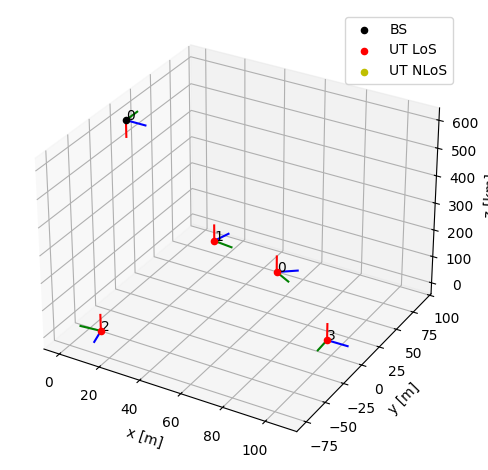

In [7]:
channel_model.show_topology()

First, it seems as if all UTs are on the same spot.However, this is just due to the scale. The expected distance between users is approximately 200m, which is very small in comparison to the 600km height of the satellite. 
Next, we see that the users all point directly towards the satellite, while the satellite points directly to the ground. This is the base setup for all topologies and follows the description in the standard 3GPP TR38.811. 
Additionally, we see that all UTs are either in LoS or Non Line of Sight (NLoS), without the indoor state. As of now, the channel models for users indoors are not defined.

With the given topology we can now have a look at the actual model. This part will only briefly describe the inputs and outputs of the channel models without describing the actual mathematical model in great detail, as that would be way too complex for this notebook. 

Just like the models in the terrestrial case, the NTN channels can be considered to be a multipath channel with each path being characterized by a complex valued gain (path coefficient) and delay (path delay). The path over which messages arrive first is considered to have a delay of 0, with every other delay being in relation to the first arriving path. Thus, the delay is not the absolut delay between transmission and receiption, but the relative delay between paths. As we consider each user to possibly have mutliple antennas, paths for each transmitter receiver antenna pair air simulated. The number of paths per pair depends on the simulation parameters but is equal for each pair in the same topology. Thus, there are a total of 
number_of_transmitters * number_transmitter_antennas * number_receivers * number_receiver_antennas * number_paths_per_pair
paths per transmission. Additionally, the simulations might be over a consecutive number of time steps and each element of a batch size, adding two more dimensions to this.

After defining a channel model and setting it's topology, we can call it to sample Channel Impulse Responses (CIRs). To do that we call the model with the number of time steps (number of times at which a message is transmitted) as well as the transmission symbol frequency. For an OFDM frame with 14 symbols, we might for example call 14 time steps and and a frequency of 1/((10^(-6))/14), as a frame typically has a duration of 1 milli second.

In [8]:
num_time_steps = 14
sampling_frequency = 14 * 10**(6)

# path_coefficients [batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
# path_delays [batch size, num_rx, num_tx, num_paths]
path_coefficients, path_delays = channel_model(num_time_steps, sampling_frequency)

Now we can go ahead and visualize a few of these attributes. Let's start with the path coefficients. The path coefficient is a complex valued number, thus it has a certain amplitude and phase. When a symbol is transmitted, it will arrive over each path, with each path coefficient being mutliplied with the symbol to add a phase shift and amplitude attenuation.

For the visualization, we plot the absolute value of the path coefficient for all paths of one Tx Rx antenna pair at one time steps. Successive time steps will reuse the same paths and only introduce a phase rotation, so for the amplitude attenuation there is no need to consider more than one time step.

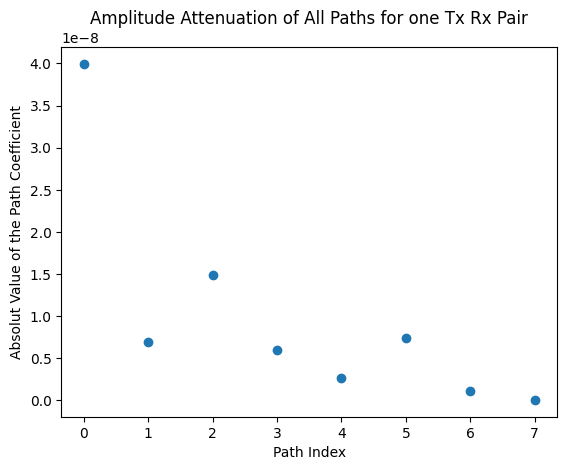

In [9]:
plt.scatter(range(len(path_coefficients[0,0,0,0,0,:,0])),tf.abs(path_coefficients[0,0,0,0,0,:,0]));
plt.xlabel("Path Index")
plt.ylabel("Absolut Value of the Path Coefficient")
plt.title("Amplitude Attenuation of All Paths for one Tx Rx Pair")
plt.show()

There is a total of 8 paths. The first has a significantly higher amplitude, the other 7 are very close to each other. With our given scenario at an elevation angle of 80 degrees, the LoS probability is more than 80%. In both the LoS and NLoS case, the UTs will receive multiple paths. However, in the LoS case, the first path will represent the LoS component and the remaining paths represent additional reflections from the environment. The LoS component has high gain and arrives first. Thus, this first path is the LoS case. By changing the elevation angle to something smaller, such as 10 degrees, the reader can quickly regenerate a new topologu with users in NLoS, to see that this first path coefficients absolute value will be lower and closer to the others as well.

Next, let's have a look at the phases. First, we plot the same paths, but this time their position in the complex plain to visualize their phases as well.

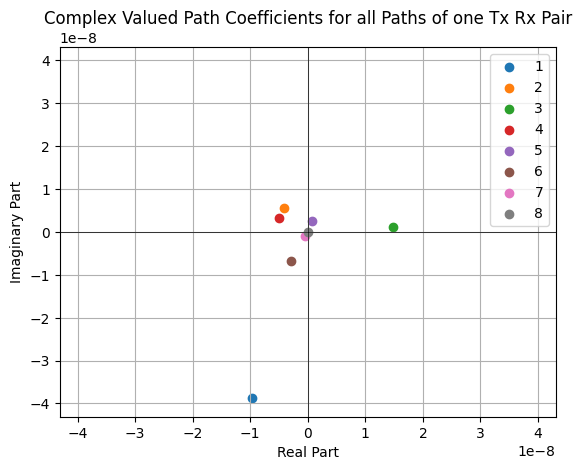

In [10]:
# Plot the imaginary and real part of each path coefficient for one Tx Rx pair and one time step
real_part = tf.math.real(path_coefficients[0,0,0,0,0,:,0])
imag_part = tf.math.imag(path_coefficients[0,0,0,0,0,:,0])

# Labels for each point
labels = ["1", "2", "3", "4", "5", "6", "7", "8"]

# Plot each point individually and assign a label
for i in range(len(labels)):
    plt.scatter(real_part[i], imag_part[i], label=labels[i])

# Add legend
plt.legend()
# Adding x and y axes through the origin
plt.axhline(0, color='black', linewidth=0.5)  # Horizontal axis (y=0)
plt.axvline(0, color='black', linewidth=0.5)  # Vertical axis (x=0)

# Adding labels for the axes
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')

real_part = tf.math.real(path_coefficients[0,0,0,0,0,0,:])
imag_part = tf.math.imag(path_coefficients[0,0,0,0,0,0,:])

max_limit = max(max(abs(real_part)), max(abs(imag_part)))*1.1
plt.xlim(-max_limit, max_limit)
plt.ylim(-max_limit, max_limit)

# Displaying the plot
plt.grid(True)  # Optional: add a grid for better visualization

plt.title("Complex Valued Path Coefficients for all Paths of one Tx Rx Pair")
plt.show()

As we can see, the first path has again the highest gain and the last path is close to 0. The phases of all paths seem about random.

To finish the section on path coefficients, we will now visualize the path coefficients of a single path at subsequent time steps.

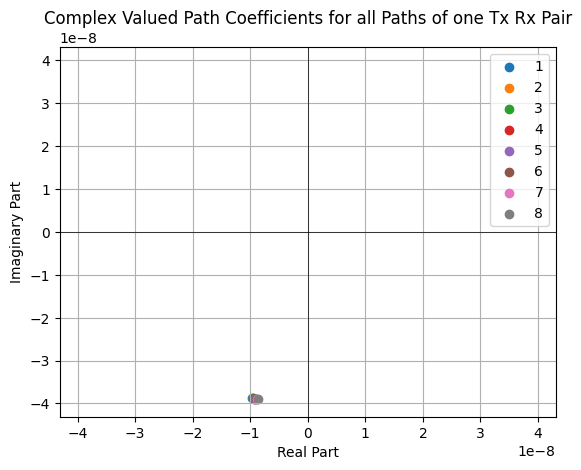

In [11]:
# Plot the imaginary and real part of each path coefficient for one Tx Rx pair and one time step
real_part = tf.math.real(path_coefficients[0,0,0,0,0,0,:])
imag_part = tf.math.imag(path_coefficients[0,0,0,0,0,0,:])

# Labels for each point
labels = ["1", "2", "3", "4", "5", "6", "7", "8"]

# Plot each point individually and assign a label
for i in range(len(labels)):
    plt.scatter(real_part[i], imag_part[i], label=labels[i])

# Add legend
plt.legend()
# Adding x and y axes through the origin
plt.axhline(0, color='black', linewidth=0.5)  # Horizontal axis (y=0)
plt.axvline(0, color='black', linewidth=0.5)  # Vertical axis (x=0)

# Adding labels for the axes
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')

real_part = tf.math.real(path_coefficients[0,0,0,0,0,0,:])
imag_part = tf.math.imag(path_coefficients[0,0,0,0,0,0,:])

max_limit = max(max(abs(real_part)), max(abs(imag_part)))*1.1
plt.xlim(-max_limit, max_limit)
plt.ylim(-max_limit, max_limit)

# Displaying the plot
plt.grid(True)  # Optional: add a grid for better visualization

plt.title("Complex Valued Path Coefficients for all Paths of one Tx Rx Pair")
plt.show()

In this example, the symbols are all very close, showing very little Doppler shift between symbols. However, one of the challenges of NTN is the potentially very significant Doppler shift. As the Doppler shift depends on relative velocity of the satellite to the UT and the UT movement, it will vary greatly based on the UT positions and orbits. A satellite in the LEO orbit has a speed of approximately 7.7km\s, which is equal to 7.7mm\microsecond so 7.7mm per OFDM frame. In the Ka-Band at 40GHz, the wavelength is approximately 7.5mm, meaning that the Symbols within one OFDM frame can expoerience a full rotation in the complex plane. We visualize this in the following code block.

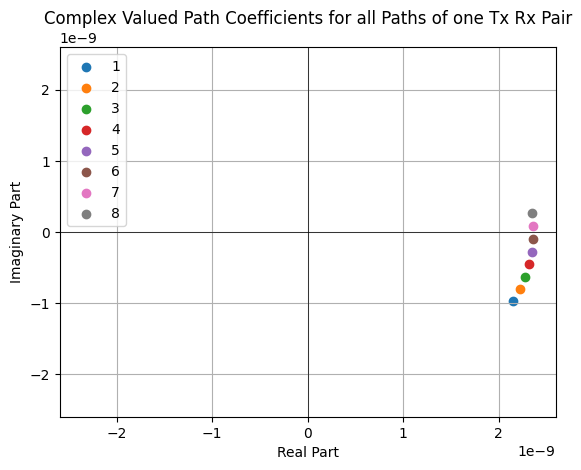

In [12]:
def visualize_large_doppler_influence():
    carrier_frequency = 40e9
    ut_array = Antenna(polarization="single",
                        polarization_type="V",
                        antenna_pattern="omni",
                        carrier_frequency=carrier_frequency)

    # The satellite is the basestation, so we name it bs. 
    bs_array = AntennaArray(num_rows=1,
                            num_cols=4,
                            polarization="dual",
                            polarization_type="VH",
                            antenna_pattern="38.901",
                            carrier_frequency=carrier_frequency)

    # Here we match choose DenseUrban to match the parameter "dur" for the scenario defined above
    channel_model = DenseUrban(carrier_frequency=carrier_frequency,
                            ut_array=ut_array,
                            bs_array=bs_array,
                            direction=direction,
                            elevation_angle=elevation_angle)

    # Generate the topology
    topology = gen_ntn_topology(batch_size=batch_size, num_ut=num_ut, scenario=scenario,bs_height=satellite_height)

    # Set the topology
    channel_model.set_topology(*topology)
    
    num_time_steps = 14
    sampling_frequency = 14 * 10**(6)

    # path_coefficients [batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
    # path_delays [batch size, num_rx, num_tx, num_paths]
    path_coefficients, path_delays = channel_model(num_time_steps, sampling_frequency)
    
    # Plot the imaginary and real part of each path coefficient for one Tx Rx pair and one time step
    real_part = tf.math.real(path_coefficients[0,0,0,0,0,0,:])
    imag_part = tf.math.imag(path_coefficients[0,0,0,0,0,0,:])

    # Labels for each point
    labels = ["1", "2", "3", "4", "5", "6", "7", "8"]

    # Plot each point individually and assign a label
    for i in range(len(labels)):
        plt.scatter(real_part[i], imag_part[i], label=labels[i])

    # Add legend
    plt.legend()
    # Adding x and y axes through the origin
    plt.axhline(0, color='black', linewidth=0.5)  # Horizontal axis (y=0)
    plt.axvline(0, color='black', linewidth=0.5)  # Vertical axis (x=0)

    # Adding labels for the axes
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')

    real_part = tf.math.real(path_coefficients[0,0,0,0,0,0,:])
    imag_part = tf.math.imag(path_coefficients[0,0,0,0,0,0,:])

    max_limit = max(max(abs(real_part)), max(abs(imag_part)))*1.1
    plt.xlim(-max_limit, max_limit)
    plt.ylim(-max_limit, max_limit)

    # Displaying the plot
    plt.grid(True)  # Optional: add a grid for better visualization

    plt.title("Complex Valued Path Coefficients for all Paths of one Tx Rx Pair")
    plt.show()
    
visualize_large_doppler_influence()

After investigating the path coefficients, we will now have a brief look at the path delays. The path delays are always generated together with the path coefficients. The path delays show the delay between multiple paths, with the first path always having a delay of 0 and the subsequent paths having a delay of x micro seconds. Thus, they are not a measure of the absolute delay between transmission and receiption, but rather a relative delay between each received path. 

Because the delays is assumed to be equal for each antenna of a transmitter or receiver, the path delays require less dimensions. Additionally, the paths are assumed to remain constant over the subsequent time steps, so that this dimension is also unnecessary. In total the path delays have a shape of [batch size, num_rx, num_tx, num_paths].

First, we will plot them similar to the absolute attenuation of the path coefficients before. Again, we plot the delay for each path of one transmitter receiver pair. For a better visualization, we will plot it both linearly and logarithmacally.


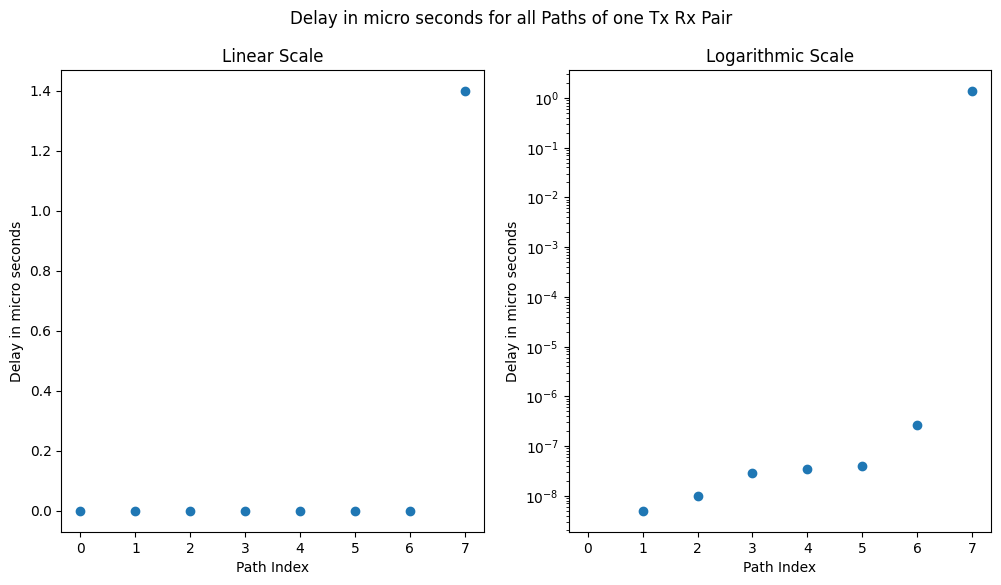

In [13]:
# Create a figure with two subplots, sharing the x-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Linear scale plot (original plot)
ax1.scatter(range(len(path_delays[0,0,0,:])), path_delays[0,0,0,:])
ax1.set_xlabel("Path Index")
ax1.set_ylabel("Delay in micro seconds")
ax1.set_title("Linear Scale")

# Logarithmic scale plot
ax2.scatter(range(len(path_delays[0,0,0,:])), path_delays[0,0,0,:])
ax2.set_yscale('log')  # Set y-axis to logarithmic scale
ax2.set_xlabel("Path Index")
ax2.set_ylabel("Delay in micro seconds")
ax2.set_title("Logarithmic Scale")

# Display the plots
plt.suptitle("Delay in micro seconds for all Paths of one Tx Rx Pair")
plt.show()

We again see 8 paths with different delays. The first path has a delay of 0 and the last path a delay that is significantly higher than the others. These delays can be used in combination with the path coefficients to generate different channel model implementations.

One of these is the OFDM channel model, which takes an entire OFDM frame and simulates the channel attenuations on all symbols of the frame. Sionna already provides different functions we can use to do just that. In the following section, we will use the channel model to generate a new OFDM channel model, the same way we would do when using the terrestrial channel models from 3GPP TR38.901 and their existing Sionna implementation. As there are already existing tutorials on the use of OFDM in Sionna, we will not explain each step in great detail.

In [14]:
# We are in Uplink and each UT only has one antenna
num_streams_per_tx = 1 

rg = ResourceGrid(num_ofdm_symbols=14,
                    fft_size=128,
                    subcarrier_spacing=30e3,
                    num_tx=num_ut,
                    num_streams_per_tx=num_streams_per_tx,
                    cyclic_prefix_length=20,
                    pilot_pattern="kronecker",
                    pilot_ofdm_symbol_indices=[2,11])

# Function that calculates the subcarrier frequencies of the OFDM frame
frequencies = subcarrier_frequencies(rg.fft_size, rg.subcarrier_spacing)

# We need a realization of the Channel Impulse Response to create the OFDM channel, so we 
# sample an arbitrary realization.
cir = channel_model(1, 1)

# h is the channel response of the new OFDM channel. This incorporates both the path coefficients and 
# path delays and results in only channel coefficients remaining by superpositioning the path shifted 
# with respect to their delay and the carrier frequency. 
# h [batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, fft_size]
h = cir_to_ofdm_channel(frequencies, *cir, normalize=True)
# h shape changes to [batch size, num_rx_ant, num_tx, fft_size]
h_visualization = tf.squeeze(h)

After generating h, we used tf.squeeze() to remove unnecessary dimensions of size 1. next, we will plot the resulting h_visualization by plotting the real and imaginary components of the channel coefficient between one transmitter receiver pair for each subcarrier frequency of the OFDM frame. 

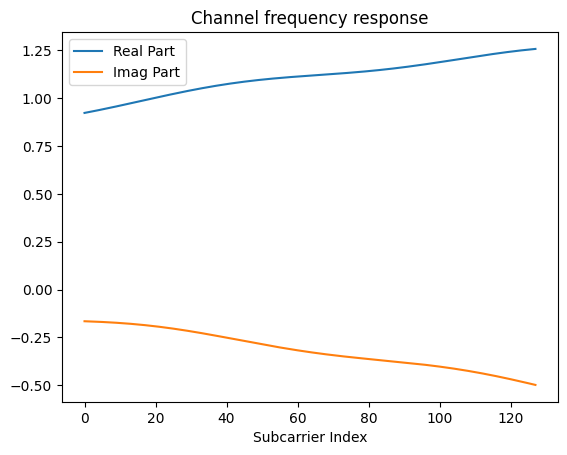

In [15]:
plt.plot(np.real(h_visualization[0,0,0,:]))
plt.plot(np.imag(h_visualization[0,0,0,:]))
plt.legend(["Real Part", "Imag Part"])
plt.xlabel("Subcarrier Index")
plt.title("Channel frequency response")
plt.show()

We can see a slight frequency selectivity in the given channel, but nothing that is too extreme. However, the result heavily depends on the elevation angle, carrier frequency and other parameters. Especially low elevations angles with high NLoS probabilities tend to have extreme frequency selectivity and small scale fading, making them hard to predict. to visualize this, we will use the condition number, which is a measure for how similar the channel is between different users. If the condition number is low, the channel is well conditioned and we can expect models to be able to approximate it well. However, if the condition number is high, the channel conditions differ heavily between users, maing channel estimation and equalization very challenging.

We define the following function to generate the CDFs of the condition number of different channels.

In [16]:
def cond_hist(scenario, elevation_angle=80.0, sat_height=600000.0, doppler_enabled=False, num_ut=2, batch_size=1024, direction="uplink", carrier_frequency = 2.0e9):
    """Generates a histogram of the channel condition numbers"""
        
    ut_array = Antenna(polarization="single",
                        polarization_type="V",
                        antenna_pattern="omni",
                        carrier_frequency=carrier_frequency)

    # The satellite will be the base station in our case
    bs_array = AntennaArray(num_rows=1,
                            num_cols=4,
                            polarization="dual",
                            polarization_type="VH",
                            antenna_pattern="38.901",
                            carrier_frequency=carrier_frequency)
    
    # Setup a CIR generator
    if scenario == "dur":
        channel_model = DenseUrban(carrier_frequency=carrier_frequency,
                                ut_array=ut_array,
                                bs_array=bs_array,
                                direction=direction,
                                elevation_angle=elevation_angle,
                                enable_pathloss=False,
                                enable_shadow_fading=False,
                                doppler_enabled=doppler_enabled)
    elif scenario == "sur":
        channel_model = SubUrban(carrier_frequency=carrier_frequency,
                                ut_array=ut_array,
                                bs_array=bs_array,
                                direction=direction,
                                elevation_angle=elevation_angle,
                                enable_pathloss=False,
                                enable_shadow_fading=False,
                                doppler_enabled=doppler_enabled)
    elif scenario == "urb":
        channel_model = Urban(carrier_frequency=carrier_frequency,
                                ut_array=ut_array,
                                bs_array=bs_array,
                                direction=direction,
                                elevation_angle=elevation_angle,
                                enable_pathloss=False,
                                enable_shadow_fading=False,
                                doppler_enabled=doppler_enabled)

    topology = gen_ntn_topology(batch_size=batch_size, num_ut=num_ut, scenario=scenario,bs_height=sat_height)

    # Set the topology
    channel_model.set_topology(*topology)

    # Generate random CIR realizations
    # As we nned only a single sample in time, the sampling_frequency
    # does not matter.
    cir = channel_model(1, 1)
    
    # Compute the frequency response
    h = cir_to_ofdm_channel(frequencies, *cir, normalize=True)
    
    h = tf.squeeze(h)
    h = tf.transpose(h, [0,3,1,2])
    
    # Compute condition number
    c = np.reshape(np.linalg.cond(h), [-1])

    # Compute normalized histogram
    hist, bins = np.histogram(c, 1000)
    hist = hist/np.sum(hist)
    return bins[:-1], hist

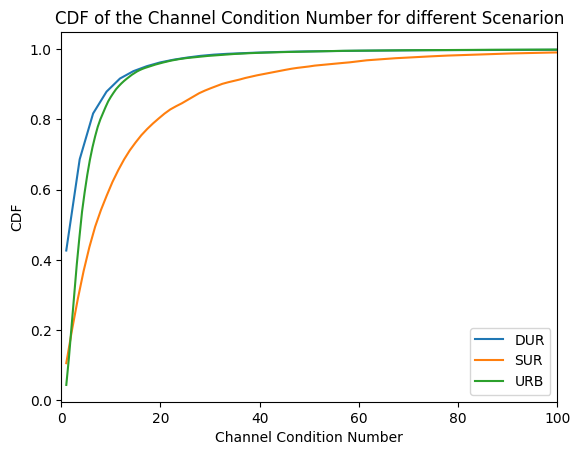

In [17]:
for scenario in ["dur", "sur", "urb"]:
    bins, hist = cond_hist(scenario, batch_size = 4096)
    plt.plot(bins, np.cumsum(hist))
    plt.legend(["DUR", "SUR", "URB"])
    plt.xlim([0,100])
    plt.xlabel("Channel Condition Number")
    plt.ylabel("CDF")
    plt.title("CDF of the Channel Condition Number for different Scenarion")

As we can see, the dense urban scenario is best conditioned, followed by the urban scenario and lastly we have the urban scenario. However,besides the scenario, other parameters also influence the condition number. We will visualize them in the following cells.

First, we take the dense urban case but vary the height.

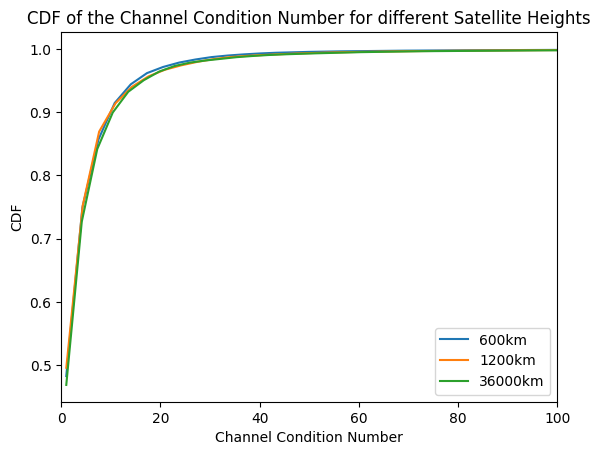

In [18]:
for satellite_height in [600000.0, 1200000.0, 36000000.0]:
    bins, hist = cond_hist(scenario="dur", sat_height=satellite_height, batch_size = 4096)
    plt.plot(bins, np.cumsum(hist))
    plt.legend(["600km", "1200km", "36000km"])
    plt.xlim([0,100])
    plt.xlabel("Channel Condition Number")
    plt.ylabel("CDF")
    plt.title("CDF of the Channel Condition Number for different Satellite Heights")

As we can see, the height does not influence the channel condition number as notably. 

Next, we will change the elevation angle.

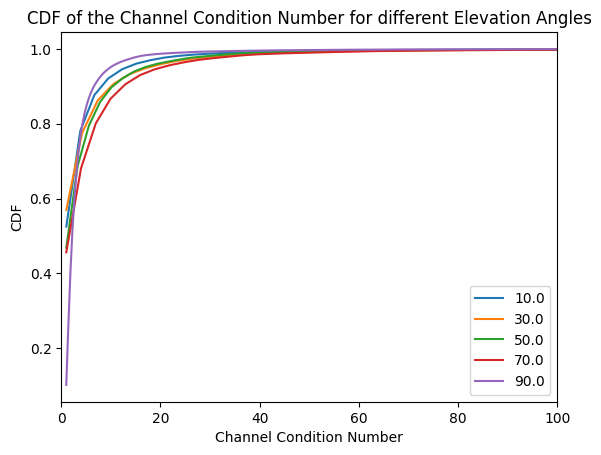

In [19]:
for elevation_angle in [10.0, 30.0, 50.0, 70.0, 90.0]:
    bins, hist = cond_hist(scenario="dur", elevation_angle=elevation_angle, batch_size = 4096)
    plt.plot(bins, np.cumsum(hist))
    plt.legend(["10.0", "30.0", "50.0", "70.0", "90.0"])
    plt.xlim([0,100])
    plt.xlabel("Channel Condition Number")
    plt.ylabel("CDF")
    plt.title("CDF of the Channel Condition Number for different Elevation Angles")

In the graph, the elevation agle of 90 degrees has the best channel condition number, with the other elevation angles closely related.

Next, we vary the influence of Doppler shift.

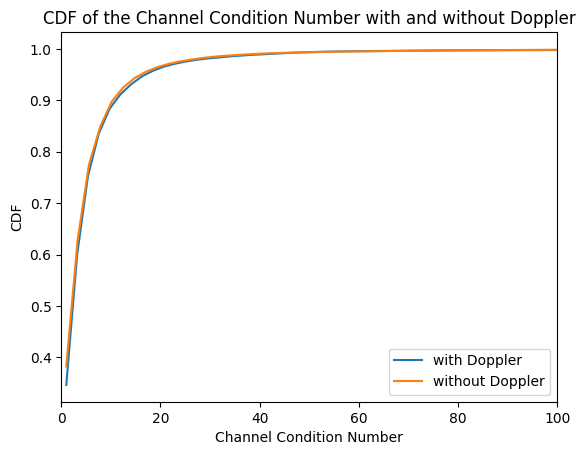

In [20]:
for with_doppler in [True, False]:
    bins, hist = cond_hist(scenario="dur", doppler_enabled=with_doppler, batch_size = 4096)
    plt.plot(bins, np.cumsum(hist))
    plt.legend(["with Doppler", "without Doppler"])
    plt.xlim([0,100])
    plt.xlabel("Channel Condition Number")
    plt.ylabel("CDF")
    plt.title("CDF of the Channel Condition Number with and without Doppler")

As we can see, the influence of Doppler degrades the channel condition number.

Next, we have a look on the number of UTs.

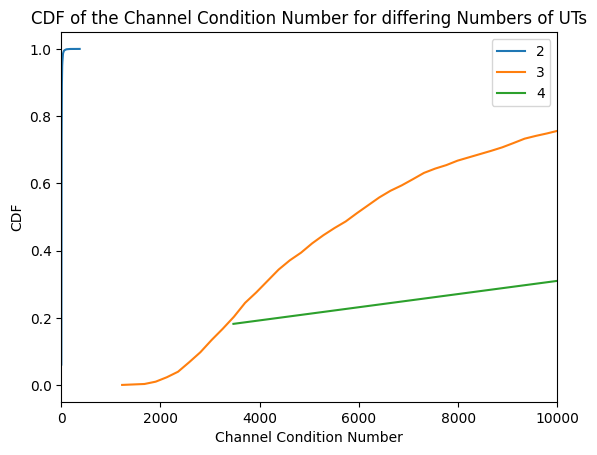

In [21]:
for num_UTs in [2, 3, 4]:
    bins, hist = cond_hist(scenario="dur", num_ut=num_UTs, batch_size = 1024)
    plt.plot(bins, np.cumsum(hist))
    plt.legend(["2", "3", "4"])
    plt.xlim([0,10000])
    plt.xlabel("Channel Condition Number")
    plt.ylabel("CDF")
    plt.title("CDF of the Channel Condition Number for differing Numbers of UTs")

As we can see, increasing the number of UTs verry quickly degrades the channel condition number extremely. Therefore scenatios with many UTs become very challenging very fast.

Lastly, we vary the carrier frequency.

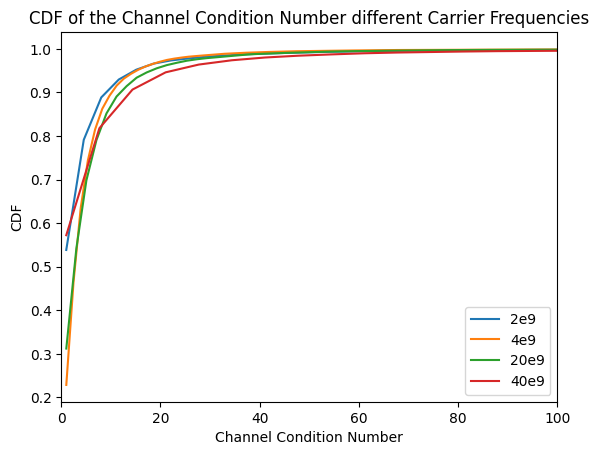

In [22]:
for carrier_frequency in [2e9, 4e9, 20e9, 40e9]:
    bins, hist = cond_hist(scenario="dur", carrier_frequency=carrier_frequency, batch_size = 4096)
    plt.plot(bins, np.cumsum(hist))
    plt.legend(["2e9", "4e9", "20e9", "40e9"])
    plt.xlim([0,100])
    plt.xlabel("Channel Condition Number")
    plt.ylabel("CDF")
    plt.title("CDF of the Channel Condition Number different Carrier Frequencies")

As we can see, the lower carrier frequencies have better condition numbers.

As a summary, we have looked at the newly implemented NTN channel models based on the 3GPP TR38.811 standard. We have had a look at how to define the models and how to generate channel impluse responses with them. By visualizing the CIRs, we created an understanding for the resulting values and their meanings. Additonally, we have shown how to genrate the common OFDM channel model with for NTN cases. Finally, we had a look at how changing different parameters of the channel model influences the channel condition number, which showcased the channels sensitivity to different parameters. In conclusion, the channels are well conditioned, as long as the number of users is small.